# Anomaly Detection using Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
from datetime import datetime

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

Using TensorFlow backend.


In [2]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###
df = pd.read_csv('sample.csv')
df.head()

df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df["total"] = pd.to_numeric(df.total, errors='coerce')
df["total_tcp"] = pd.to_numeric(df.total_tcp, errors='coerce')
df["total_http"] = pd.to_numeric(df.total_http, errors='coerce')
df["total_udp"] = pd.to_numeric(df.total_udp, errors='coerce')
df["size"] = pd.to_numeric(df.size, errors='coerce')
df["size_tcp"] = pd.to_numeric(df.size_tcp, errors='coerce')
df["size_http"] = pd.to_numeric(df.size_http, errors='coerce')
df["size_udp"] = pd.to_numeric(df.size_udp, errors='coerce')



df.dtypes
df.head()

,datetime,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp
0,2012-03-16 12:35:00,15769,3361,9316,3092,89982,3743,3214,2630
1,2012-03-16 12:40:00,17375,3506,8374,5495,89982,5198,4925,1881
2,2012-03-16 12:45:00,17282,8002,6580,2700,89982,152,9859,7499
3,2012-03-16 12:50:00,19928,9734,3700,6494,89982,4840,1963,7909
4,2012-03-16 12:55:00,15027,2735,3497,8795,89982,9049,3,8731


In [3]:
df.dtypes

datetime      datetime64[ns]
total                  int64
total_tcp              int64
total_http             int64
total_udp              int64
size                   int64
size_tcp               int64
size_http              int64
size_udp               int64
dtype: object

In [4]:
df.head()

,datetime,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp
0,2012-03-16 12:35:00,15769,3361,9316,3092,89982,3743,3214,2630
1,2012-03-16 12:40:00,17375,3506,8374,5495,89982,5198,4925,1881
2,2012-03-16 12:45:00,17282,8002,6580,2700,89982,152,9859,7499
3,2012-03-16 12:50:00,19928,9734,3700,6494,89982,4840,1963,7909
4,2012-03-16 12:55:00,15027,2735,3497,8795,89982,9049,3,8731


In [5]:
df.columns = ['timestamp','total','total_tcp','total_http','total_udp','size','size_tcp','size_http','size_udp']


(array([22213355, 22220640, 22233350]), <a list of 3 Text xticklabel objects>)

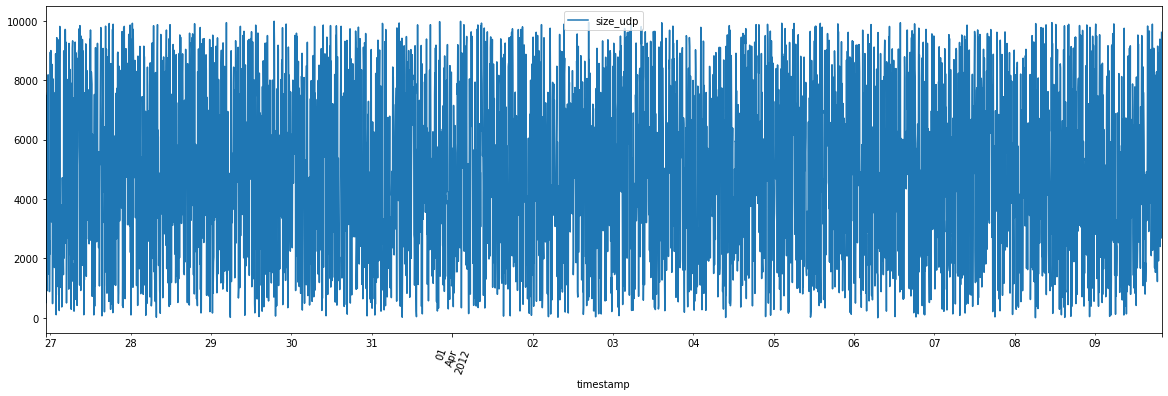

In [6]:
df.iloc[3000:7000,].plot(y='size_udp',x='timestamp',figsize=(20,6))
plt.xticks(rotation=70)

/Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


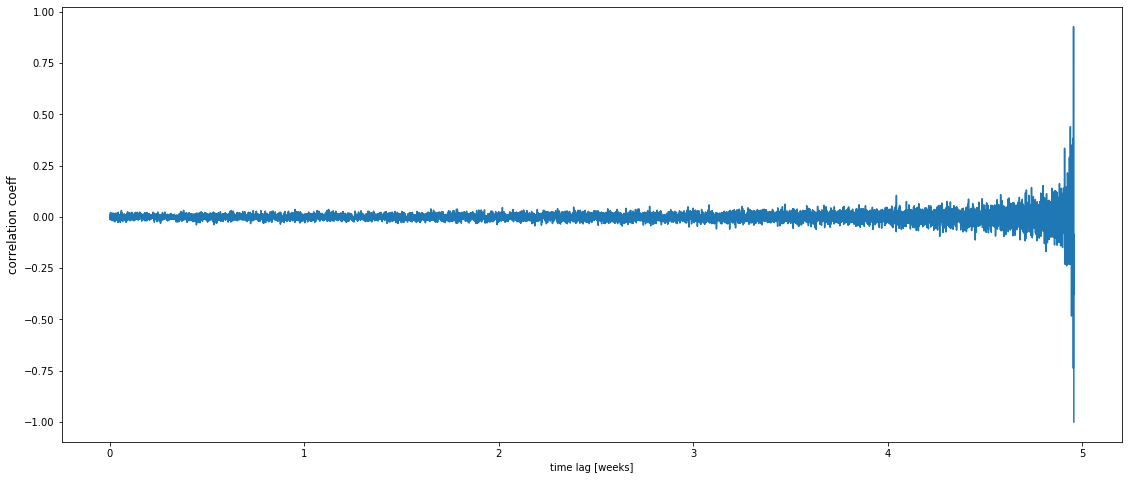

In [7]:
### WEEKLY AUTOCORR PLOT (5 WEEKS DEPTH) ###
timeLags = np.arange(1,288*7*5)
autoCorr = [df.total.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(288 * 7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [8]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###
weekday = df['timestamp'].dt.dayofweek
df['weekday'] = weekday

H = df['timestamp'].dt.hour
df['H'] = H

df.head()

,timestamp,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp,weekday,H
0,2012-03-16 12:35:00,15769,3361,9316,3092,89982,3743,3214,2630,4,12
1,2012-03-16 12:40:00,17375,3506,8374,5495,89982,5198,4925,1881,4,12
2,2012-03-16 12:45:00,17282,8002,6580,2700,89982,152,9859,7499,4,12
3,2012-03-16 12:50:00,19928,9734,3700,6494,89982,4840,1963,7909,4,12
4,2012-03-16 12:55:00,15027,2735,3497,8795,89982,9049,3,8731,4,12


In [9]:
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['size_udp'].mean().to_dict())

In [10]:
df.head()

,timestamp,total,total_tcp,total_http,total_udp,size,size_tcp,size_http,size_udp,weekday,H,weekday_hour,m_weekday
0,2012-03-16 12:35:00,15769,3361,9316,3092,89982,3743,3214,2630,4,12,4 12,5090.241379
1,2012-03-16 12:40:00,17375,3506,8374,5495,89982,5198,4925,1881,4,12,4 12,5090.241379
2,2012-03-16 12:45:00,17282,8002,6580,2700,89982,152,9859,7499,4,12,4 12,5090.241379
3,2012-03-16 12:50:00,19928,9734,3700,6494,89982,4840,1963,7909,4,12,4 12,5090.241379
4,2012-03-16 12:55:00,15027,2735,3497,8795,89982,9049,3,8731,4,12,4 12,5090.241379


In [11]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 288

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [12]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['size_udp']):
    cnt.append(sequence)

In [13]:
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(9710, 288, 1)

In [14]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.size_udp[sequence_length:].apply(np.log).values - init
label.shape

(9710,)

In [15]:
### DEFINE QUANTILE LOSS ###
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [16]:
### TRAIN TEST SPLIT ###
X_train, X_test = cnt[:7000], cnt[7000:]
y_train, y_test = label[:7000], label[7000:]

In [17]:
### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

W0813 06:17:31.267713 4499858880 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 06:17:31.303874 4499858880 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 06:17:31.308226 4499858880 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 06:17:31.481881 4499858880 deprecation.py:506] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow

In [18]:
history = model.fit(X_train, [y_train,y_train,y_train], epochs=5, batch_size=128, verbose=2, shuffle=True)

W0813 06:17:33.088220 4499858880 deprecation.py:323] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0813 06:17:35.520594 4499858880 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0813 06:17:35.731964 4499858880 deprecation_wrapper.py:119] From /Users/bhanukagamage/anaconda3/envs/apicta/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5
 - 130s - loss: 0.2181 - dense_2_loss: 0.2708 - dense_3_loss: 0.3411 - dense_4_loss: 0.1151
Epoch 2/5
 - 121s - loss: 0.1984 - dense_2_loss: 0.2230 - dense_3_loss: 0.3410 - dense_4_loss: 0.0973
Epoch 3/5
 - 120s - loss: 0.1982 - dense_2_loss: 0.2228 - dense_3_loss: 0.3412 - dense_4_loss: 0.0967
Epoch 4/5
 - 118s - loss: 0.1980 - dense_2_loss: 0.2220 - dense_3_loss: 0.3411 - dense_4_loss: 0.0968
Epoch 5/5
 - 119s - loss: 0.1977 - dense_2_loss: 0.2216 - dense_3_loss: 0.3408 - dense_4_loss: 0.0966


In [19]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

100%|██████████| 100/100 [14:15<00:00,  9.38s/it]


In [46]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[len(init) - len(X_test):])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[len(init) - len(X_test)])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[len(init) - len(X_test):])

In [47]:
### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test + init[len(init) - len(X_test):]), pred_50_m)

1.1114270448722583

In [48]:
len(init) - len(X_test)

7000

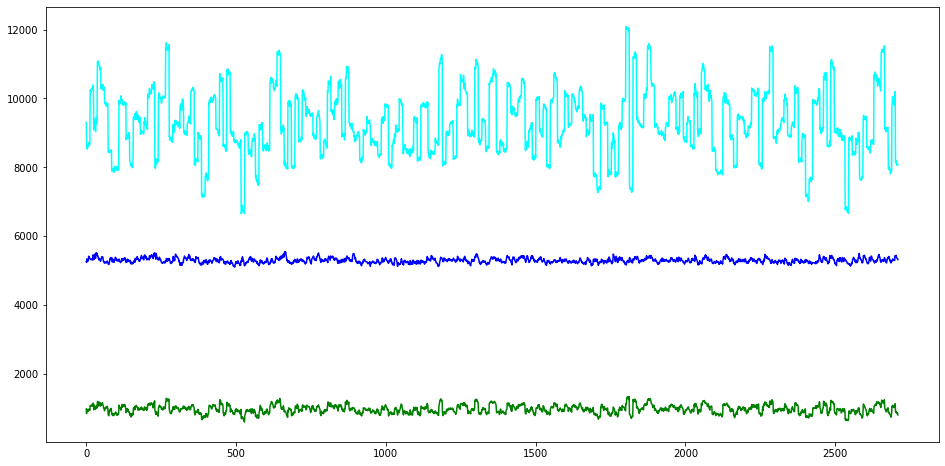

In [49]:
### PLOT QUANTILE PREDICTIONS ###
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')

### CROSSOVER CHECK ###
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

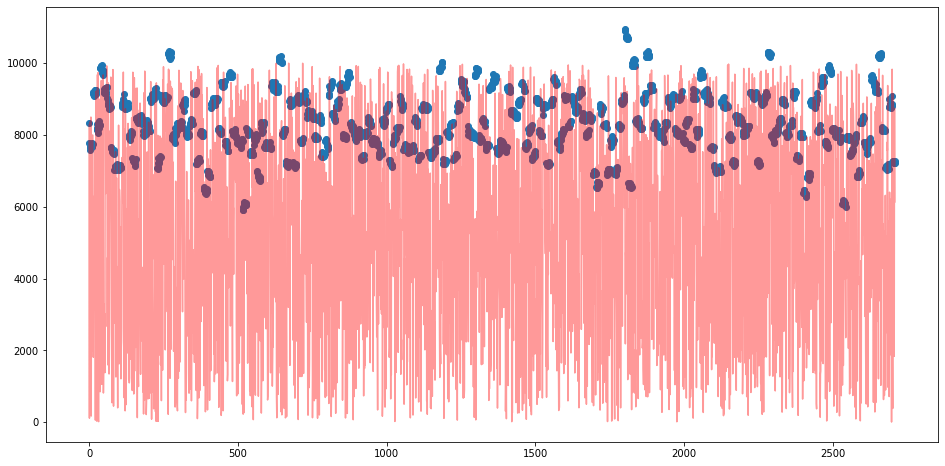

In [52]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test + init[len(init) - len(X_test):]), color='red', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)

In [54]:
x = pred_90_m - pred_10_m
x[:100]

array([8328.10350239, 7787.78974214, 7660.97926431, 7574.90744812,
       7655.93907775, 7650.60255921, 7670.7010712 , 7714.51242066,
       7733.07133993, 7765.27282223, 7664.37586156, 7687.96429677,
       7737.54984316, 9135.76290083, 9188.64140302, 9074.72426026,
       9160.9617193 , 9123.02057159, 9195.86775409, 9167.7189601 ,
       9262.93367403, 9258.3078282 , 9248.51282255, 9194.29906443,
       9136.02047979, 8131.07215085, 8157.80905877, 8302.27326352,
       8192.27380712, 8154.37795288, 8159.7509731 , 8061.68976019,
       8281.46839237, 8389.98076358, 8202.40439803, 8281.68040686,
       8290.00318138, 9866.42471992, 9876.89017961, 9829.76480627,
       9933.0535818 , 9914.79814169, 9934.70748993, 9804.59194845,
       9735.44142721, 9790.09440154, 9671.4755385 , 9715.48070615,
       9815.96182442, 9207.98517736, 9169.50887306, 9266.0361255 ,
       9249.92879288, 9238.99949275, 9219.7987674 , 9310.84034457,
       9146.87079422, 9181.58275652, 9295.99655043, 9345.63529